In [18]:
import numpy as np
import os, sys
from pathlib import Path
from hist import intervals

sys.path.append("/users/hep/eigen1907/Workspace/Workspace-RPC/modules")
from NanoAODTnP.Plotting.DataLoader import DataLoader
from NanoAODTnP.Plotting.Hist1D import init_figure

In [2]:
underflow2022 = {
    'RE+1_R2_CH01_C' 'RE+1_R2_CH11_A' 'RE+1_R2_CH11_B' 'RE+1_R2_CH11_C'
    'RE+1_R2_CH25_A' 'RE+1_R2_CH29_B' 'RE+1_R3_CH04_A' 'RE+2_R2_CH23_A'
    'RE+2_R3_CH32_A' 'RE+3_R3_CH16_C' 'RE+3_R3_CH21_B' 'RE+3_R3_CH21_C'
    'RE+4_R3_CH02_A' 'RE+4_R3_CH17_A' 'RE+4_R3_CH17_B' 'RE+4_R3_CH17_C'
    'RE-1_R2_CH11_C' 'RE-1_R3_CH02_B' 'RE-1_R3_CH17_B' 'RE-2_R2_CH30_A'
    'RE-2_R2_CH30_B' 'RE-2_R2_CH32_B' 'RE-3_R2_CH19_A' 'RE-3_R2_CH19_B'
    'W+0_RB2in_S04_Forward' 'W+0_RB2in_S05_Forward' 'W+0_RB3-_S03_Forward'
    'W+1_RB3+_S02_Forward' 'W+1_RB3-_S09_Forward' 'W+1_RB4-_S01_Forward'
    'W+2_RB2in_S03_Forward' 'W-1_RB2in_S11_Backward' 'W-1_RB3+_S11_Backward'
    'W-2_RB3-_S07_Backward'
}

underflow2023 = {
    'RE+1_R2_CH01_C' 'RE+1_R2_CH11_A' 'RE+1_R2_CH11_B' 'RE+1_R2_CH11_C'
    'RE+1_R2_CH25_A' 'RE+1_R3_CH18_B' 'RE+2_R2_CH03_A' 'RE+2_R2_CH23_A'
    'RE+2_R3_CH22_A' 'RE+2_R3_CH32_A' 'RE+2_R3_CH33_A' 'RE+2_R3_CH33_B'
    'RE+2_R3_CH33_C' 'RE+3_R3_CH16_C' 'RE+3_R3_CH21_B' 'RE+3_R3_CH21_C'
    'RE+4_R3_CH02_A' 'RE+4_R3_CH17_A' 'RE+4_R3_CH17_B' 'RE+4_R3_CH17_C'
    'RE-1_R2_CH11_C' 'RE-2_R2_CH30_A' 'RE-2_R2_CH30_B' 'RE-2_R2_CH32_B'
    'RE-3_R2_CH19_A' 'RE-3_R2_CH19_B' 'RE-3_R2_CH30_A' 'RE-3_R2_CH30_B'
    'RE-3_R2_CH30_C' 'W+0_RB2in_S04_Forward' 'W+0_RB2in_S05_Forward'
    'W+0_RB3-_S03_Forward' 'W+1_RB3+_S02_Forward' 'W+1_RB3-_S09_Forward'
    'W+1_RB4-_S01_Forward' 'W+2_RB2in_S03_Forward' 'W-1_RB2in_S11_Backward'
    'W-1_RB2out_S09_Forward' 'W-1_RB3+_S11_Backward' 'W-1_RB4-_S06_Forward'
    'W-2_RB3-_S07_Backward'
}

In [37]:
workspace = Path('/users/hep/eigen1907/Workspace/Workspace-RPC')

input_2022_path = workspace / 'data' / 'efficiency' / 'data' / 'Run2022.root'
roll_blacklist_2022_path = workspace / 'data' / 'efficiency' / 'blacklist' / 'roll-blacklist-2022.json'

input_2023_path = workspace / 'data' / 'efficiency' / 'data' / 'Run2023.root'
roll_blacklist_2023_path = workspace / 'data' / 'efficiency' / 'blacklist' / 'roll-blacklist-2023.json'

geom_path = workspace / 'data' / 'efficiency' / 'geometry' / 'run3.csv'

data_2022 = DataLoader(
    input_path = input_2022_path,
    geom_path = geom_path,
    roll_blacklist_path = roll_blacklist_2022_path,
    var = ['run']
)

data_2022 = data_2022.filter_data(keys = ['is_fiducial', 'is_linked'])

barrel_data_2022 = data_2022.filter_data(region = 'Barrel')
endcap_data_2022 = data_2022.filter_data(region = 'Endcap')

data_2023 = DataLoader(
    input_path = input_2023_path,
    geom_path = geom_path,
    roll_blacklist_path = roll_blacklist_2023_path,
    var = ['run']
)

data_2023 = data_2023.filter_data(keys = ['is_fiducial', 'is_linked'])

barrel_data_2023 = data_2023.filter_data(region = 'Barrel')
endcap_data_2023 = data_2023.filter_data(region = 'Endcap')

import pandas as pd
run_info = pd.read_csv("/users/hep/eigen1907/Workspace/Workspace-RPC/data/efficiency/run_info/run_info.csv", index_col=False)

/users/hep/eigen1907/micromamba/envs/ds4hep/lib/python3.11/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/users/hep/eigen1907/micromamba/envs/ds4hep/lib/python3.11/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


In [105]:
from datetime import datetime

def plot_eff_run(ax, data):
    tree = data.tree 
    runs = np.unique(tree['run'])
    effs, err_uppers, err_lowers = [], [], []
    for run in runs:
        run_mask = (tree['run'] == run)

        total = tree['is_matched'][run_mask]
        passed = total[total]
        
        eff = len(passed) / len(total) * 100
        err = intervals.clopper_pearson_interval(len(passed), len(total), 0.68) * 100
        
        effs.append(eff)
        err_lowers.append(eff - err[0])
        err_uppers.append(err[1] - eff)

    ax.errorbar(
        runs,
        effs,
        yerr = (err_lowers, err_uppers),
        fmt = '.',
        capsize = 2,
        color = data.facecolors[1],
        label = data.region,
    )
    return ax

def run2time(run, run_info):
    time = None
    while True:
        if time is not None: break
        if round(run) in run_info['run_number'].values:
            time = run_info['start_time'][run_info['run_number'] == round(run)].values[0]
            time = datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
        run += 1
    return time

def plot_eff_time(ax, data, run_info):
    tree = data.tree 
    runs = np.unique(tree['run'])
    times = []
    effs, err_uppers, err_lowers = [], [], []
    for run in runs:
        times.append(run2time(run, run_info))
        run_mask = (tree['run'] == run)

        total = tree['is_matched'][run_mask]
        passed = total[total]
        
        eff = len(passed) / len(total) * 100
        err = intervals.clopper_pearson_interval(len(passed), len(total), 0.68) * 100
        
        effs.append(eff)
        err_lowers.append(eff - err[0])
        err_uppers.append(err[1] - eff)

    ax.errorbar(
        times,
        effs,
        yerr = (err_lowers, err_uppers),
        fmt = '.',
        capsize = 2,
        color = data.facecolors[1],
        label = data.region,
    )
    return ax

In [104]:
test = 1.3
print(round(test))

test = 1
print(type(round(test)))
print(run_info['run_number'])
print(355100 in run_info['run_number'].values)

1
<class 'int'>
0       355100
1       355101
2       355102
3       355103
4       355104
         ...  
7427    371208
7428    371213
7429    371216
7430    371224
7431    371225
Name: run_number, Length: 7432, dtype: int64
True


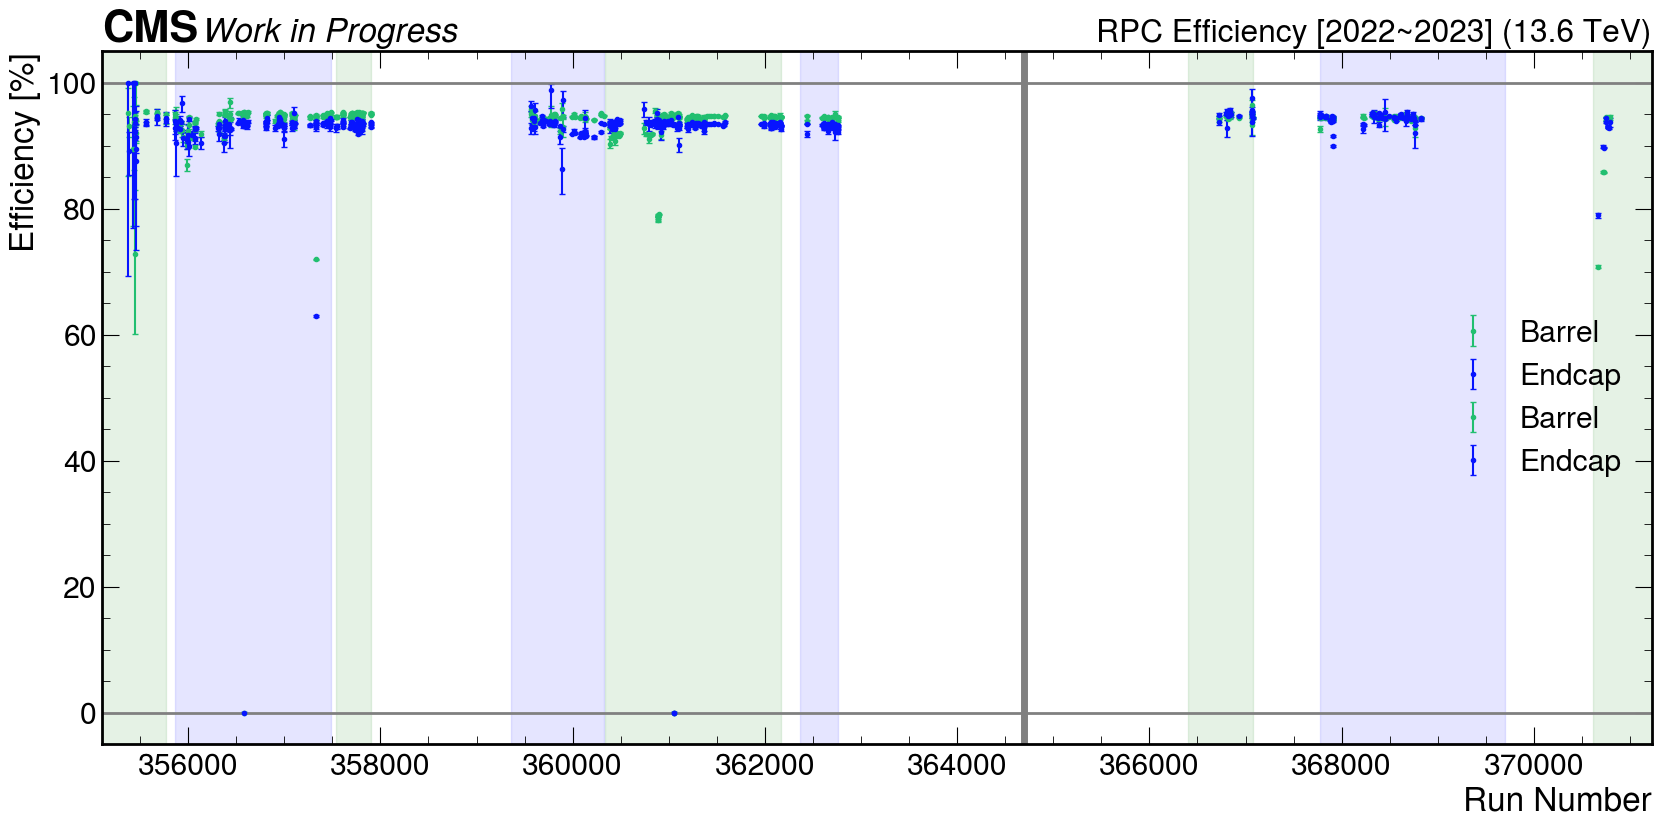

In [83]:
fig, ax = init_figure(
    figsize = (20, 9),
    fontsize = 24,
    com = 13.6,
    label1 = 'Work in Progress',
    label2 = f'RPC Efficiency [2022~2023]',
    loc = 0,
    xlabel = 'Run Number',
    ylabel = 'Efficiency [%]',
    xlim = None,
    ylim = None,
    xticks = None,
    yticks = None,
    log_scale = False,
)

ax.set_ylim(-5, 105)
ax.set_xlim(355100, 371225)

plot_eff_run(ax, barrel_data_2022)
plot_eff_run(ax, endcap_data_2022)
plot_eff_run(ax, barrel_data_2023)
plot_eff_run(ax, endcap_data_2023)

ax.axvspan(355100, 355769, color='g', alpha=0.1)
ax.axvspan(355862, 357482, color='b', alpha=0.1)
ax.axvspan(357538, 357900, color='g', alpha=0.1)
ax.axvspan(359356, 360327, color='b', alpha=0.1)
ax.axvspan(360335, 362167, color='g', alpha=0.1)
ax.axvspan(362362, 362760, color='b', alpha=0.1)

ax.axvspan(366403, 367079, color='g', alpha=0.1)
ax.axvspan(367770, 369694, color='b', alpha=0.1)
ax.axvspan(370616, 371225, color='g', alpha=0.1)

ax.plot(np.ones(120)*364699, np.linspace(-10, 110, 120), color='gray', lw=5)
ax.plot(np.linspace(320000, 380000, 100), np.linspace(0, 0, 100), color='gray', lw=2)
ax.plot(np.linspace(320000, 380000, 100), np.linspace(100, 100, 100), color='gray', lw=2)

ax.legend(loc = 'center right')

output_dir = Path('/users/hep/eigen1907/Workspace/Workspace-RPC/240425-TnP_RPC24/Plotting/Scatter-run-eff')

if not output_dir.exists():
    output_dir.mkdir(parents=True)

fig.savefig(output_dir / f"with_blacklist_run.png")

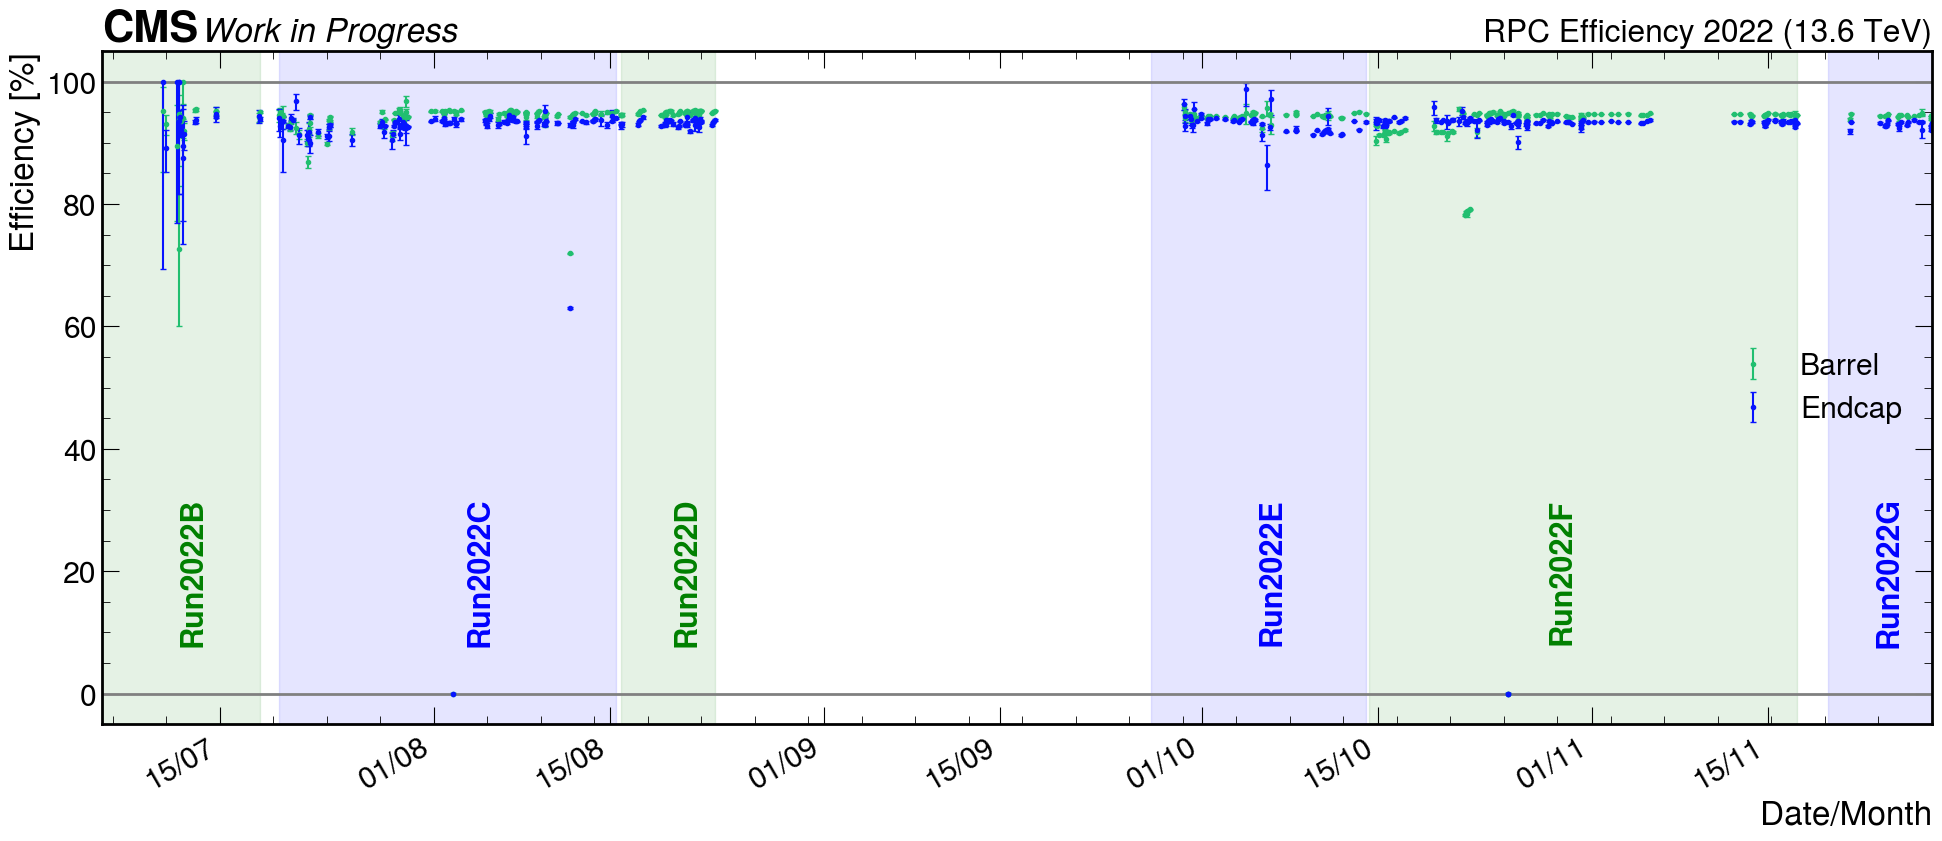

In [113]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from pathlib import Path

# Initialize the figure (assuming init_figure is a predefined function)
fig, ax = init_figure(
    figsize=(20, 9),
    fontsize=24,
    com=13.6,
    label1='Work in Progress',
    label2=f'RPC Efficiency 2022',
    loc=0,
    xlabel='Date/Month',
    ylabel='Efficiency [%]',
    xlim=None,
    ylim=None,
    xticks=None,
    yticks=None,
    log_scale=False,
)

# Set y-axis limits
ax.set_ylim(-5, 105)

# Set x-axis limits (assuming run2time and run_info are predefined)
ax.set_xlim(run2time(355100, run_info), run2time(362760, run_info))

# Plot efficiency data (assuming plot_eff_time is a predefined function)
plot_eff_time(ax, barrel_data_2022, run_info)
plot_eff_time(ax, endcap_data_2022, run_info)

# Add colored spans with annotations
spans = [
    (355100, 355769, 'Run2022B', 'g'),
    (355862, 357482, 'Run2022C', 'b'),
    (357538, 357900, 'Run2022D', 'g'),
    (359356, 360327, 'Run2022E', 'b'),
    (360335, 362167, 'Run2022F', 'g'),
    (362362, 362760, 'Run2022G', 'b'),
]

for start, end, label, color in spans:
    ax.axvspan(run2time(start, run_info), run2time(end, run_info), color=color, alpha=0.1)
    mid_point = run2time((start + end) // 2, run_info)
    ax.text(mid_point, 20, label, rotation=90, verticalalignment='center', fontsize=22, weight='bold', color=color)

# Add additional lines
ax.plot([run2time(355100, run_info), run2time(362760, run_info)], [0, 0], color='gray', lw=2)
ax.plot([run2time(355100, run_info), run2time(362760, run_info)], [100, 100], color='gray', lw=2)

# Set x-axis major ticks to be on the 1st and 15th of each month and format the ticks to display day/month
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=(1, 15)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))

# Tilt x-axis tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# Adjust layout to make space for labels
plt.tight_layout(rect=[0, 0, 1, 1])  # Optionally, you can fine-tune this

# Add legend
ax.legend(loc='center right')

# Save the figure
output_dir = Path('/users/hep/eigen1907/Workspace/Workspace-RPC/240425-TnP_RPC24/Plotting/Scatter-run-eff')

if not output_dir.exists():
    output_dir.mkdir(parents=True)

fig.savefig(output_dir / "with_blacklist_time_2022.png")

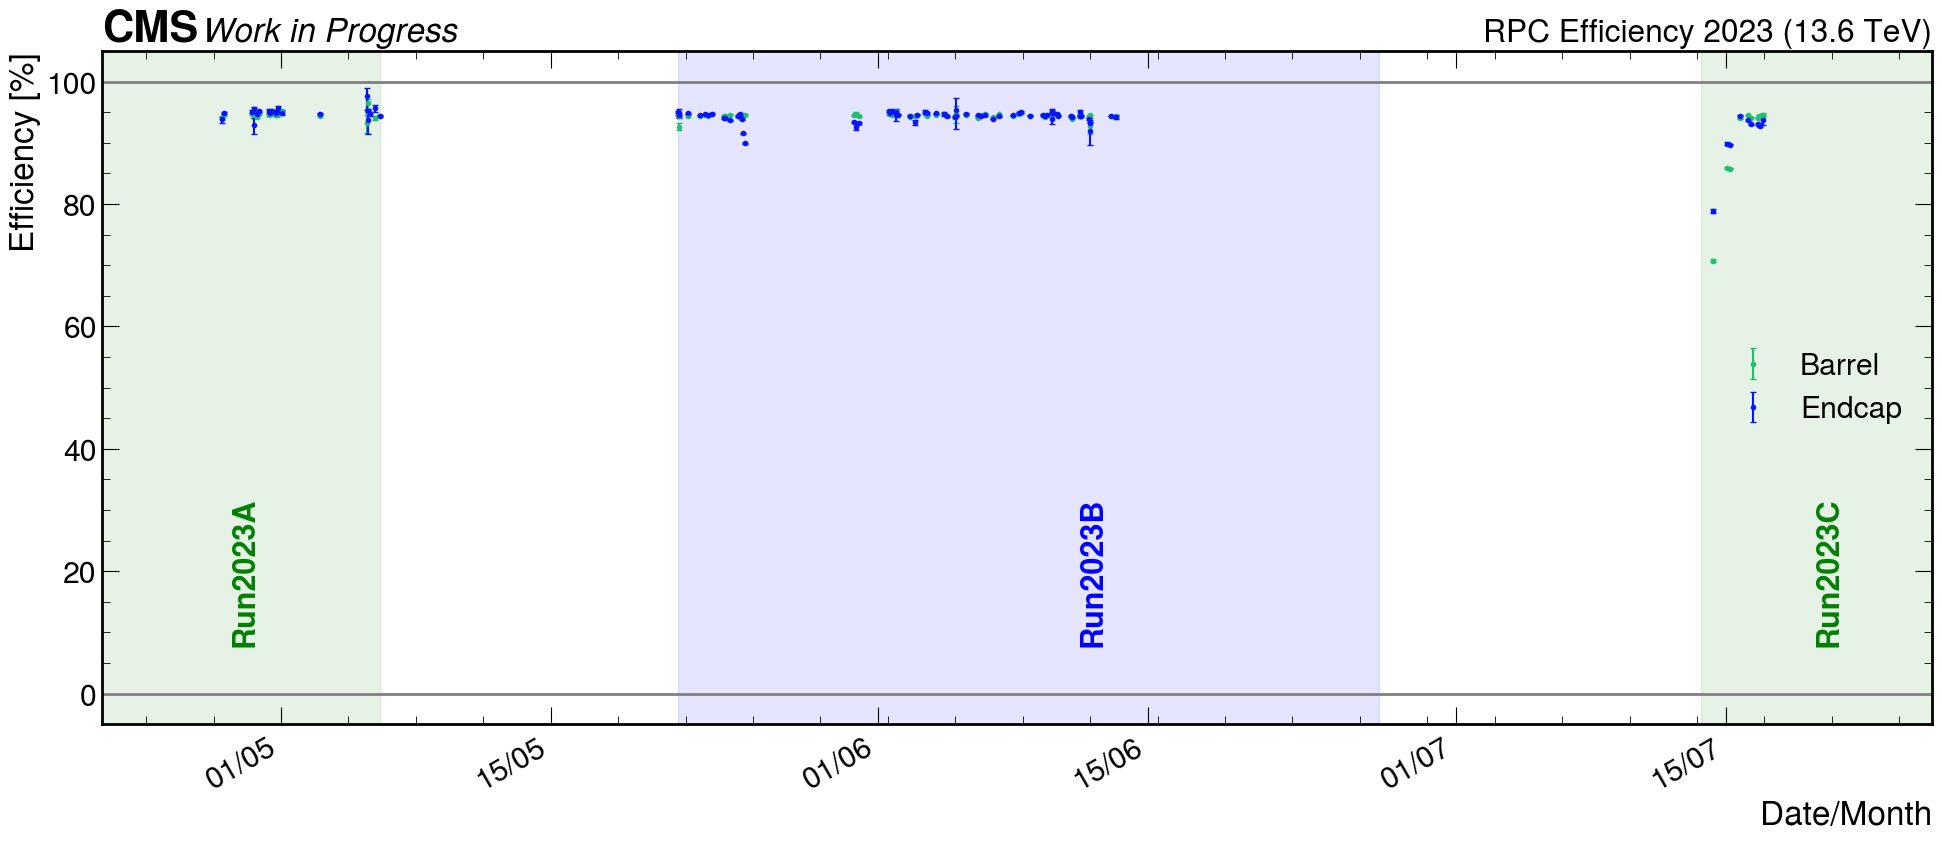

In [112]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from pathlib import Path

# Initialize the figure (assuming init_figure is a predefined function)
fig, ax = init_figure(
    figsize=(20, 9),
    fontsize=24,
    com=13.6,
    label1='Work in Progress',
    label2=f'RPC Efficiency 2023',
    loc=0,
    xlabel='Date/Month',
    ylabel='Efficiency [%]',
    xlim=None,
    ylim=None,
    xticks=None,
    yticks=None,
    log_scale=False,
)

# Set y-axis limits
ax.set_ylim(-5, 105)

# Set x-axis limits (assuming run2time and run_info are predefined)
ax.set_xlim(run2time(366403, run_info), run2time(371225, run_info))

# Plot efficiency data (assuming plot_eff_time is a predefined function)
plot_eff_time(ax, barrel_data_2023, run_info)
plot_eff_time(ax, endcap_data_2023, run_info)

# Add colored spans with annotations
spans = [
    (366403, 367079, 'Run2023A', 'g'),
    (367770, 369694, 'Run2023B', 'b'),
    (370616, 371225, 'Run2023C', 'g'),
]

for start, end, label, color in spans:
    ax.axvspan(run2time(start, run_info), run2time(end, run_info), color=color, alpha=0.1)
    mid_point = run2time((start + end) // 2, run_info)
    ax.text(mid_point, 20, label, rotation=90, verticalalignment='center', fontsize=22, weight='bold', color=color)

# Add additional lines
ax.plot([run2time(366403, run_info), run2time(371225, run_info)], [0, 0], color='gray', lw=2)
ax.plot([run2time(366403, run_info), run2time(371225, run_info)], [100, 100], color='gray', lw=2)

# Set x-axis major ticks to be on the 1st and 15th of each month and format the ticks to display day/month
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=(1, 15)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))

# Tilt x-axis tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# Adjust layout to make space for labels
plt.tight_layout(rect=[0, 0, 1, 1])  # Optionally, you can fine-tune this

# Add legend
ax.legend(loc='center right')

# Save the figure
output_dir = Path('/users/hep/eigen1907/Workspace/Workspace-RPC/240425-TnP_RPC24/Plotting/Scatter-run-eff')

if not output_dir.exists():
    output_dir.mkdir(parents=True)

fig.savefig(output_dir / "with_blacklist_time_2023.png")